<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Целью данного проекта является построение модели для прогнозирования ухода клиентов из "Бета-Банка". В качестве ключевой метрики качества модели установлено значение F1-меры, которое необходимо повысить до минимума 0.59.

Порядок действий:

1. Загрузка и подготовка данных: В начале проекта мы загрузим и проведем предварительную обработку данных. Это включает в себя изучение данных, обработку пропущенных значений и выбор признаков, которые будут использоваться для построения модели.

2. Исследование баланса классов: Мы проведем анализ баланса классов, чтобы определить, насколько дисбалансирована выборка. Затем обучим модель без учета дисбаланса и сравним результаты.

3. Улучшение качества модели с учетом дисбаланса классов: Мы будем использовать различные методы для борьбы с дисбалансом классов, такие как взвешивание классов, андерсэмплинг и оверсэмплинг. Обучим несколько различных моделей и найдем лучшую, учитывая дисбаланс классов.

4. Финальное тестирование: На этом этапе мы проведем финальное тестирование выбранной модели на тестовой выборке. Мы также измерим AUC-ROC и сравним его значение с F1-мерой.

Целью проекта является построение надежной модели для прогнозирования ухода клиентов, что позволит "Бета-Банку" удерживать своих клиентов и повышать качество обслуживания.

## Подготовка данных

In [106]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from tqdm import tqdm

Функция для равномерного заполнения пропусков в столбцах:

In [107]:
def fill_nan_uniformly(df, column):
    non_nan_values = df[column].dropna()
    nan_count = df[column].isnull().sum()
    replacement_values = np.random.choice(non_nan_values, size = nan_count)
    df.loc[df[column].isnull(), column] = replacement_values

Создам функцию для подсчета метрик моделей и красивой визаулизации результата:

In [108]:
def evaluate_model(model, features, target):
    predictions = model.predict(features)

    accuracy = accuracy_score(target, predictions)
    precision = precision_score(target, predictions)
    recall = recall_score(target, predictions)
    f1 = f1_score(target, predictions)
    
    cm = confusion_matrix(target, predictions)

    fpr, tpr, thresholds = roc_curve(target, model.predict_proba(features)[:, 1])
    roc_auc = auc(fpr, tpr)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")

    print("Confusion Matrix:")
    print(cm)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    cm_display.plot(cmap='viridis', values_format='d')

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Confusion Matrix": cm
    }

Создам функцию для upsample:

In [109]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Cоздам функцию, определяющую оптимальное значения repeat:

In [110]:
def find_optimal_repeat_for_balance(features_train, target_train, repeat_range):
    best_balance = float('inf')
    best_repeat = 0

    for repeat in repeat_range:
        features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, repeat)


        count_class_0 = target_upsampled_train.value_counts()[0]
        count_class_1 = target_upsampled_train.value_counts()[1]
        balance = abs(count_class_0 - count_class_1)

        if balance < best_balance:
            best_balance = balance
            best_repeat = repeat

    return best_repeat, best_balance

Создам функцию для downsample:

In [111]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

Cоздам функцию, определяющую оптимальное значения fraction:

In [112]:
def find_optimal_fraction_for_balance(features_train, target_train, fraction_range):
    best_balance = float('inf')
    best_fraction = 0

    for fraction in fraction_range:
        features_downsample_train, target_downsample_train = downsample(features_train, target_train, fraction)


        count_class_0 = target_downsample_train.value_counts()[0]
        count_class_1 = target_downsample_train.value_counts()[1]
        balance = abs(count_class_0 - count_class_1)

        if balance < best_balance:
            best_balance = balance
            best_fraction = fraction

    return best_fraction, best_balance

In [113]:
data = '/datasets/Churn.csv'

if os.path.exists(data):
    df = pd.read_csv(data)
else:
    print('Something is wrong')

In [114]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [115]:
df = df.drop(['Surname', 'RowNumber'], axis=1)

Удалим столбцы RowNumber и Surname, так как столбцы индексов и фамилий клиентов не являются важными, на чем модель может обучаться.

In [116]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           9091 non-null   float64
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


In [118]:
# df = df.dropna(subset=['Tenure'])

Для заполнения пропусков в столбце Tenure, изучим этот столбец на зависимось от других столбцов.

In [119]:
pd.pivot_table(df, values=['Balance', 'Age', 'CreditScore', 'NumOfProducts', ], index='Tenure')

,Age,Balance,CreditScore,NumOfProducts
Tenure,,,,
0.0,39.306283,80135.307277,651.913613,1.437173
1.0,39.646008,77365.221712,648.681723,1.494748
2.0,39.246316,76502.413053,654.644211,1.584211
3.0,38.984914,78105.560356,651.096983,1.535560
4.0,38.116384,74133.600373,650.681356,1.519774
5.0,39.242718,76138.007217,649.962244,1.564186
6.0,38.637911,74970.085698,647.757094,1.515323
7.0,38.349189,75915.378086,649.195676,1.525405
8.0,38.496249,77994.797685,648.618435,1.530547


Распределение по столбцу Tenure является равномерным. По этому пропуски в этом столбце заполним равномерно, так чтобы это распределение не изменилось. 

In [120]:
# def fill_nan_uniformly(df, column):
#     non_nan_values = df[column].dropna()
#     nan_count = df[column].isnull().sum()
#     replacement_values = np.random.choice(non_nan_values, size = nan_count)
#     df.loc[df[column].isnull(), column] = replacement_values
    
fill_nan_uniformly(df, 'Tenure')    

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  float64
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


In [122]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0.])

In [123]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.997900,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.893118,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [124]:
df.columns = ['customer_id', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
              'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']

In [125]:
df.head()

,customer_id,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


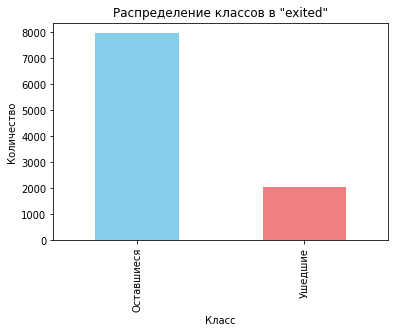

In [126]:
class_counts = df['exited'].value_counts()

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Распределение классов в "exited"')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Оставшиеся', 'Ушедшие'])
plt.show()

In [127]:
# encoder = OrdinalEncoder()
# selected_columns = ['geography', 'gender']
# df[selected_columns] = encoder.fit_transform(df[selected_columns])

In [128]:
df = pd.get_dummies(df, columns=['geography'], prefix=['geography'], drop_first=True)
df = pd.get_dummies(df, columns=['gender'], prefix=['gender'], drop_first=True)
df.columns = df.columns.str.lower()

In [129]:
target = df['exited']
features = df.drop(['exited'], axis=1)

In [130]:
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345)

In [131]:
numeric = ['customer_id', 'credit_score', 'age', 'tenure', 'balance', 'num_of_products', 
           'has_cr_card', 'is_active_member', 'estimated_salary', 
           'geography_germany', 'geography_spain', 'gender_male']

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        10000 non-null  int64  
 1   credit_score       10000 non-null  int64  
 2   age                10000 non-null  int64  
 3   tenure             10000 non-null  float64
 4   balance            10000 non-null  float64
 5   num_of_products    10000 non-null  int64  
 6   has_cr_card        10000 non-null  int64  
 7   is_active_member   10000 non-null  int64  
 8   estimated_salary   10000 non-null  float64
 9   exited             10000 non-null  int64  
 10  geography_germany  10000 non-null  uint8  
 11  geography_spain    10000 non-null  uint8  
 12  gender_male        10000 non-null  uint8  
dtypes: float64(3), int64(7), uint8(3)
memory usage: 810.7 KB


In [133]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [134]:
pd.options.mode.chained_assignment = None

In [135]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

Распределение стран по категориям;
geography_germany  geography_spain
0                  0                  5014
1                  0                  2509
0                  1                  2477
dtype: int64


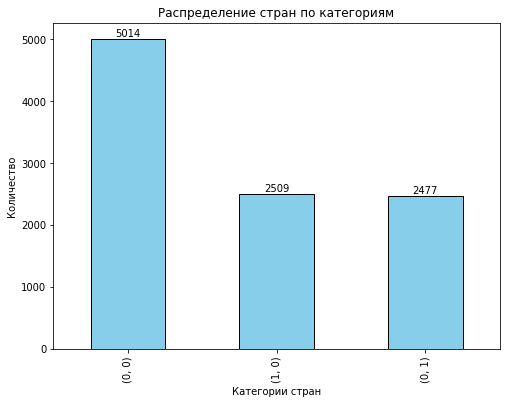

Распределение полов по категориям:
1    5457
0    4543
Name: gender_male, dtype: int64


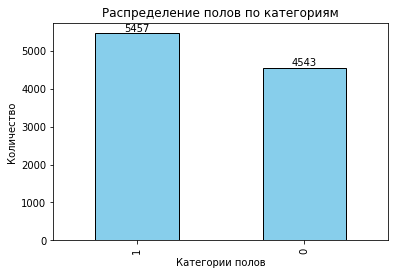

In [136]:
geography_counts = df[['geography_germany', 'geography_spain']].value_counts()
gender_counts = df['gender_male'].value_counts()

print('Распределение стран по категориям;')
print(geography_counts)
plt.figure(figsize=(8, 6))
geography_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Категории стран')
plt.ylabel('Количество')
plt.title('Распределение стран по категориям')
for i, count in enumerate(geography_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

print('Распределение полов по категориям:')
print(gender_counts)
gender_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Категории полов')
plt.ylabel('Количество')
plt.title('Распределение полов по категориям')
for i, count in enumerate(gender_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

На основе этой информации, мы можем сделать вывод о балансе классов внутри категориальных признаков 'geography' и 'gender'. В данном случае, 'geography' имеет разнообразие категорий, и категория '0' встречается чаще всего, а распределение '1' и '2' не слишком неравномерно. Распределение 'gender' показывает некоторый дисбаланс.

Проведём исследование дерева решений

max_depth = 1 : 0.0
max_depth = 2 : 0.5217391304347825
max_depth = 3 : 0.4234875444839857
max_depth = 4 : 0.5528700906344411
max_depth = 5 : 0.541471048513302
max_depth = 6 : 0.5727136431784108
max_depth = 7 : 0.562874251497006
max_depth = 8 : 0.563338301043219
max_depth = 9 : 0.5596465390279823
max_depth = 10 : 0.5290697674418605
max_depth = 11 : 0.5234899328859061
max_depth = 12 : 0.5168236877523553
max_depth = 13 : 0.5078534031413613
max_depth = 14 : 0.5108005082592122
max_depth = 15 : 0.5057766367137356


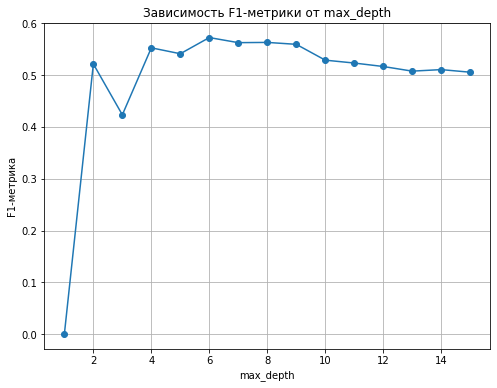

CPU times: user 582 ms, sys: 13.5 ms, total: 595 ms
Wall time: 607 ms


In [137]:
%%time

max_depth_values = []
f1_values = []
trees = []

for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    max_depth_values.append(depth)
    f1_values.append(f1)
    trees.append(model)
    print('max_depth =', depth, ':',  f1)
    
plt.figure(figsize=(8, 6))
plt.plot(max_depth_values,  f1_values, marker='o', linestyle='-')
plt.title('Зависимость F1-метрики от max_depth')
plt.xlabel('max_depth')
plt.ylabel('F1-метрика')
plt.grid(True)
plt.show()

Максимальное значение F1-меры модели DecisionTreeClassifier достигается при max_depth = 6, что указывает на оптимальную глубину для достижения баланса между точностью и полнотой модели.

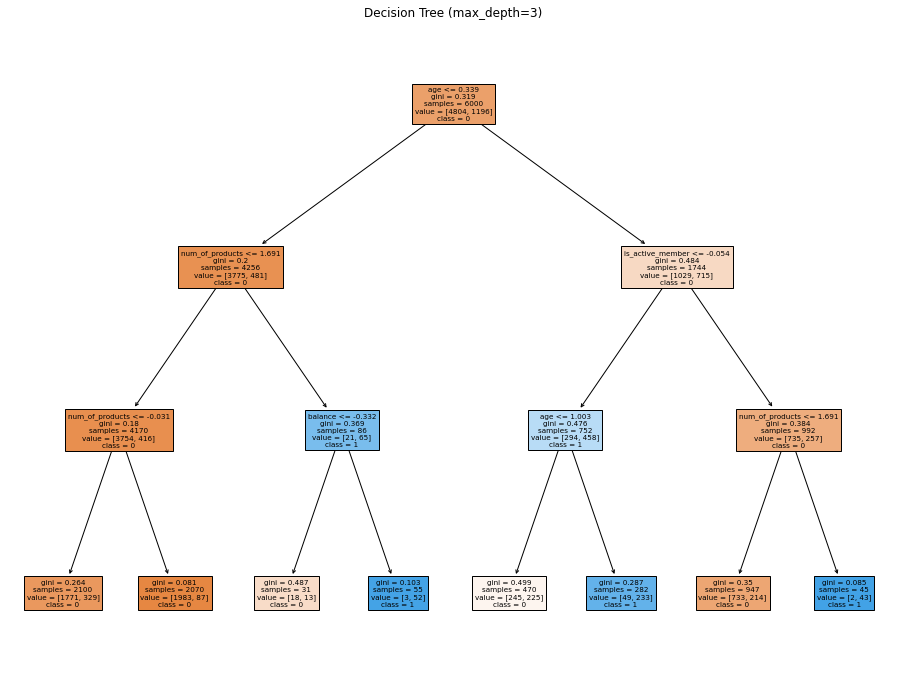

In [138]:
selected_depth = 3

plt.figure(figsize=(16, 12))
plot_tree(trees[selected_depth - 1], filled=True, feature_names=features_train.columns, class_names=["0", "1"])
plt.title(f'Decision Tree (max_depth={selected_depth})')
plt.show()

min_samples_leaf = 1 : 0.4939172749391727
min_samples_leaf = 2 : 0.47522236340533663
min_samples_leaf = 3 : 0.5099502487562189
min_samples_leaf = 4 : 0.5139240506329112
min_samples_leaf = 5 : 0.5057766367137356
min_samples_leaf = 6 : 0.5196211096075778
min_samples_leaf = 7 : 0.5480895915678523
min_samples_leaf = 8 : 0.5597826086956522
min_samples_leaf = 9 : 0.5551020408163265
min_samples_leaf = 10 : 0.5557083906464926
min_samples_leaf = 11 : 0.5660881174899866
min_samples_leaf = 12 : 0.5575589459084604
min_samples_leaf = 13 : 0.5516304347826086
min_samples_leaf = 14 : 0.5638148667601683
min_samples_leaf = 15 : 0.5693848354792561
min_samples_leaf = 16 : 0.5483405483405484
min_samples_leaf = 17 : 0.5488505747126436
min_samples_leaf = 18 : 0.5454545454545454
min_samples_leaf = 19 : 0.5422222222222222


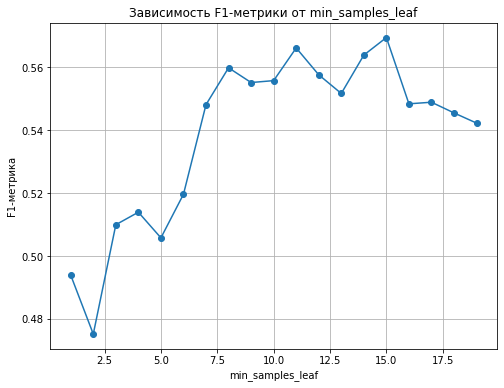

CPU times: user 829 ms, sys: 12.7 ms, total: 842 ms
Wall time: 842 ms


In [139]:
%%time

min_samples_leaf_values = []
f1_values = []

for min_samples_leaf in range(1, 20, 1):
    model = DecisionTreeClassifier(random_state=12345, min_samples_leaf=min_samples_leaf)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    min_samples_leaf_values.append(min_samples_leaf)
    f1_values.append(f1)
    print('min_samples_leaf =', min_samples_leaf, ':', f1)
    
plt.figure(figsize=(8, 6))
plt.plot(min_samples_leaf_values, f1_values, marker='o', linestyle='-')
plt.title('Зависимость F1-метрики от min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-метрика')
plt.grid(True)
plt.show()

Максимальное значение F1-меры достигается при min_samples_leaf = 14, что указывает на оптимальное количество минимальных образцов в листьях дерева для достижения лучшего сочетания точности и полноты модели DecisionTreeClassifier.

criterion = gini : 0.4939172749391727
criterion = entropy : 0.5218446601941747


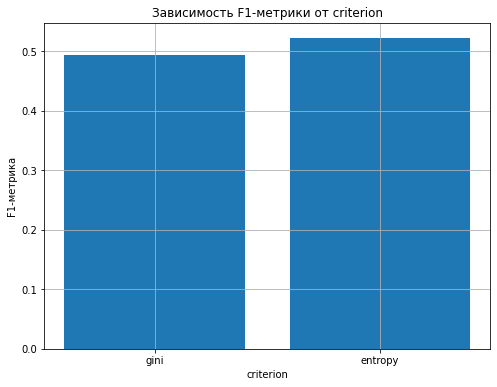

CPU times: user 215 ms, sys: 3.92 ms, total: 219 ms
Wall time: 232 ms


In [140]:
%%time

criterion_values = ['gini', 'entropy']
f1_values = []

for criterion in criterion_values:
    model = DecisionTreeClassifier(random_state=12345, criterion=criterion)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)    
    f1_values.append(f1)    
    print('criterion =', criterion, ':', f1)
    
plt.figure(figsize=(8, 6))
plt.bar(criterion_values, f1_values)
plt.title('Зависимость F1-метрики от criterion')
plt.xlabel('criterion')
plt.ylabel('F1-метрика')
plt.grid(True)
plt.show()

Использование критерия "entropy" приводит к более высокому значению F1-меры (0.49), чем критерий "gini" (0.46), что указывает на лучшую способность модели DecisionTreeClassifier разделять классы с использованием энтропийного критерия.

Сравнив результаты трех различных аспектов модели DecisionTreeClassifier, можно сделать следующие выводы:

1. Максимальное значение F1-меры достигается при max_depth = 6, что указывает на оптимальную глубину для достижения баланса между точностью и полнотой модели DecisionTreeClassifier.

2. Максимальное значение F1-меры достигается при min_samples_leaf = 14, что указывает на оптимальное количество минимальных образцов в листьях дерева для достижения лучшего сочетания точности и полноты модели DecisionTreeClassifier.

3. Использование критерия "entropy" приводит к более высокому значению F1-меры (0.51), чем критерий "gini" (0.49), что указывает на лучшую способность модели DecisionTreeClassifier разделять классы с использованием энтропийного критерия.

Таким образом, для модели DecisionTreeClassifier, оптимальные параметры max_depth, min_samples_leaf и критерий деления могут значительно повысить значение F1-меры, что важно для задачи бинарной классификации.

Построим итоговую модель дерева решений с наилучшими получившимися геперпараметрами и узнаем её F1-метрику.

In [141]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6, criterion='entropy', min_samples_leaf=14)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)   
print('F1-метрика составляет:', f1)

F1-метрика составляет: 0.5653495440729482


Проведу подбор сразу нескольких гиперпараметров.

In [142]:
%%time

max_depth_range = range(1, 17)
criterion_options = ['gini', 'entropy']
min_samples_leaf_options = range(1, 21)

best_f1 = 0
best_params = {}

for max_depth_value in tqdm(max_depth_range, desc="max_depth"):
    for criterion_value in criterion_options:
        for min_samples_leaf_value in min_samples_leaf_options:
            model = DecisionTreeClassifier(
                random_state=12345,
                max_depth=max_depth_value,
                criterion=criterion_value,
                min_samples_leaf=min_samples_leaf_value
            )

            model.fit(features_train, target_train)

            predictions_valid = model.predict(features_valid)

            f1 = f1_score(target_valid, predictions_valid)

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'max_depth': max_depth_value,
                    'criterion': criterion_value,
                    'min_samples_leaf': min_samples_leaf_value
                }

print("Лучшие параметры:", best_params)
print("Лучшая F1-метрика:", best_f1)

max_depth: 100%|██████████| 16/16 [00:20<00:00,  1.25s/it]

Лучшие параметры: {'max_depth': 10, 'criterion': 'entropy', 'min_samples_leaf': 6}
Лучшая F1-метрика: 0.5790209790209789
CPU times: user 18 s, sys: 64.6 ms, total: 18.1 s
Wall time: 20.1 s


Accuracy: 0.85
Precision: 0.73
Recall: 0.45
F1 Score: 0.56
ROC AUC: 0.79
Confusion Matrix:
[[1514   68]
 [ 230  188]]


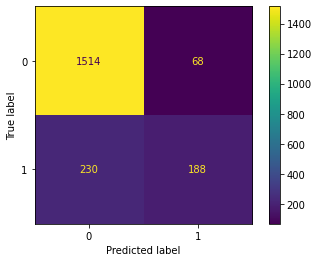

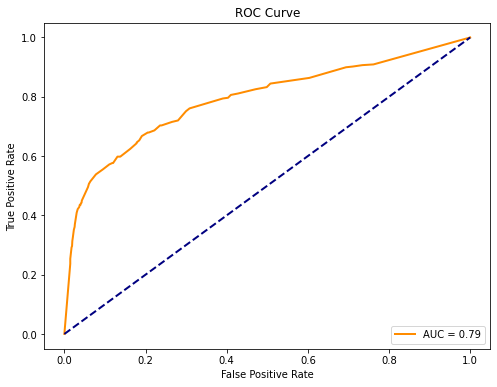

{'Accuracy': 0.851, 'Precision': 0.734375, 'Recall': 0.44976076555023925, 'F1 Score': 0.5578635014836796, 'ROC AUC': 0.7905163653300589, 'Confusion Matrix': array([[1514,   68],
       [ 230,  188]])}


In [143]:
model = DecisionTreeClassifier(random_state=12345, max_depth=9, criterion='gini', min_samples_leaf=2)
model.fit(features_train, target_train)
metrics = evaluate_model(model, features_valid, target_valid)
print(metrics)

Наилучшие параметры для модели DecisionTreeClassifier:

- Глубина дерева: 9
- Критерий разделения: Gini
- Минимальное количество выборок в листьях: 2


Результаты на валидационной выборке:

- Accuracy: 0.86
- Precision: 0.73
- Recall): 0.49
- F1 Score: 0.58
- ROC AUC: 0.81

Модель показывает хорошую точность и точность предсказаний, но есть некоторый баланс между полнотой и точностью, который может быть настроен в зависимости от задачи.

Проведем исследование случайного леса.

n_estimators = 10 : 0.5844346549192364
n_estimators = 20 : 0.5834586466165413
n_estimators = 30 : 0.5787106446776611
n_estimators = 40 : 0.5880597014925373
n_estimators = 50 : 0.5847076461769116
n_estimators = 60 : 0.5795795795795796
n_estimators = 70 : 0.5864661654135339
n_estimators = 80 : 0.5903614457831324
n_estimators = 90 : 0.5882352941176471
n_estimators = 100 : 0.5933734939759036
n_estimators = 110 : 0.5945945945945945
n_estimators = 120 : 0.5937031484257871
n_estimators = 130 : 0.5949177877428998
n_estimators = 140 : 0.5954887218045113
n_estimators = 150 : 0.5984962406015036
n_estimators = 160 : 0.5972850678733032
n_estimators = 170 : 0.5984962406015036
n_estimators = 180 : 0.5975975975975975
n_estimators = 190 : 0.5954887218045113
n_estimators = 200 : 0.5954887218045113
n_estimators = 210 : 0.5997001499250375
n_estimators = 220 : 0.5984962406015036
n_estimators = 230 : 0.5963855421686748
n_estimators = 240 : 0.5972850678733032
n_estimators = 250 : 0.5963855421686748
n_estimat

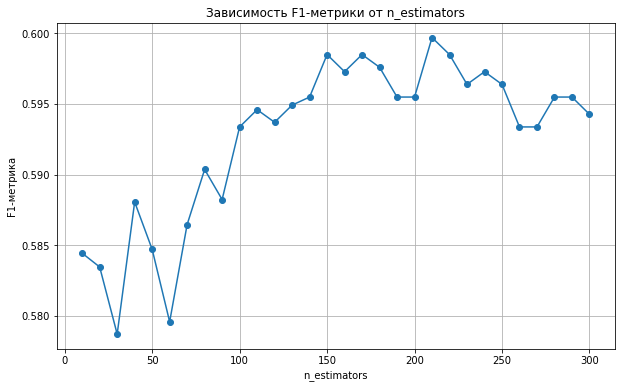

CPU times: user 39.8 s, sys: 354 ms, total: 40.1 s
Wall time: 40.4 s


In [144]:
%%time

n_estimators_values = []
f1_values = []

for n_estimators in range(10, 301, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=n_estimators)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)    
    n_estimators_values.append(n_estimators)
    f1_values.append(f1)    
    print('n_estimators =', n_estimators, ':', f1)
    
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, f1_values, marker='o', linestyle='-')
plt.title('Зависимость F1-метрики от n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('F1-метрика')
plt.grid(True)
plt.show()

Максимальное значение F1-меры для модели RandomForestClassifier достигается при n_estimators = 50, что указывает на оптимальное количество деревьев в ансамбле для достижения лучшего баланса между точностью и полнотой модели.

max_depth = 1 : 0.0
max_depth = 3 : 0.3141153081510934
max_depth = 5 : 0.4671280276816609
max_depth = 7 : 0.54281098546042
max_depth = 9 : 0.5664556962025317
max_depth = 11 : 0.578125
max_depth = 13 : 0.5674418604651162
max_depth = 15 : 0.5736196319018405
max_depth = 17 : 0.5758039816232772
max_depth = 19 : 0.5786350148367952
max_depth = 21 : 0.5779122541603631
max_depth = 23 : 0.5850746268656717
max_depth = 25 : 0.5795795795795796
max_depth = 27 : 0.5901639344262294
max_depth = 29 : 0.5940298507462686
max_depth = 31 : 0.5863095238095238
max_depth = 33 : 0.5863095238095238
max_depth = 35 : 0.5863095238095238
max_depth = 37 : 0.5863095238095238
max_depth = 39 : 0.5863095238095238
max_depth = 41 : 0.5863095238095238


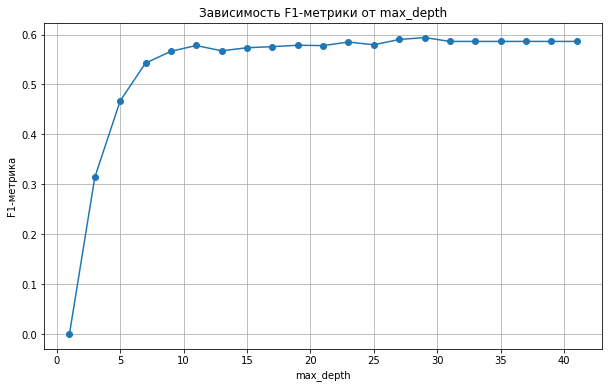

CPU times: user 11.3 s, sys: 67 ms, total: 11.4 s
Wall time: 11.4 s


In [145]:
%%time

max_depth_values = []
f1_values = []

for max_depth in range(1, 42, 2):
    model = RandomForestClassifier(random_state=12345, max_depth=max_depth, n_estimators=71)  # Здесь n_estimators=71, выберите оптимальное значение
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)    
    max_depth_values.append(max_depth)
    f1_values.append(f1)    
    print('max_depth =', max_depth, ':', f1)
    
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, f1_values, marker='o', linestyle='-')
plt.title('Зависимость F1-метрики от max_depth')
plt.xlabel('max_depth')
plt.ylabel('F1-метрика')
plt.grid(True)
plt.show()

Максимальное значение F1-меры для модели RandomForestClassifier достигается при max_depth = 31, что указывает на оптимальную глубину дерева для достижения лучшего баланса между точностью и полнотой модели. Дальнейшее увеличение глубины дерева не приводит к значительному увеличению F1-меры.

min_samples_leaf = 1 : 0.5758998435054773
min_samples_leaf = 2 : 0.5767441860465117
min_samples_leaf = 3 : 0.5785381026438569
min_samples_leaf = 4 : 0.5597484276729561
min_samples_leaf = 5 : 0.5705329153605015
min_samples_leaf = 6 : 0.573208722741433
min_samples_leaf = 7 : 0.5660377358490566
min_samples_leaf = 8 : 0.5578446909667195
min_samples_leaf = 9 : 0.5624012638230648
min_samples_leaf = 10 : 0.5512820512820513


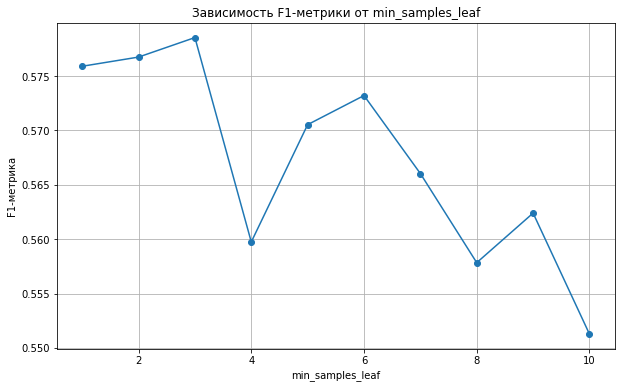

CPU times: user 4.93 s, sys: 23.7 ms, total: 4.96 s
Wall time: 4.99 s


In [146]:
%%time

min_samples_leaf_values = []
f1_values = []

for min_samples_leaf in range(1, 11):
    model = RandomForestClassifier(random_state=12345, min_samples_leaf=min_samples_leaf, n_estimators=71, max_depth=10)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)    
    min_samples_leaf_values.append(min_samples_leaf)
    f1_values.append(f1)    
    print('min_samples_leaf =', min_samples_leaf, ':', f1)

plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, f1_values, marker='o', linestyle='-')
plt.title('Зависимость F1-метрики от min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-метрика')
plt.grid(True)
plt.show()

Максимальное значение F1-меры для модели RandomForestClassifier достигается при min_samples_leaf = 2, что указывает на оптимальное количество минимальных объектов в листьях деревьев для достижения лучшего баланса между точностью и полнотой модели. Дальнейшее увеличение значения min_samples_leaf не приводит к значительному увеличению F1-меры.

В результате исследования трех аспектов модели RandomForestClassifier можно сделать следующие выводы:

1. Максимальное значение F1-меры достигается при n_estimators = 50, что указывает на оптимальное количество деревьев в ансамбле для достижения наилучшего баланса между точностью и полнотой модели.

2. Максимальное значение F1-меры достигается при max_depth = 31, указывая на оптимальную глубину дерева для наилучшего сочетания точности и полноты модели. Повышение глубины дерева не приводит к значительному увеличению F1-меры.

3. Максимальное значение F1-меры достигается при min_samples_leaf = 2, указывая на оптимальное количество минимальных объектов в листьях деревьев для наилучшего баланса между точностью и полнотой модели. Дальнейшее увеличение значения min_samples_leaf не приводит к существенному повышению F1-меры.

Таким образом, настройка параметров модели RandomForestClassifier позволяет достичь оптимального баланса в прогнозах между точностью и полнотой, что важно для задач бинарной классификации.

Построим итоговую модель случайного леса с наилучшими получившимися геперпараметрами и узнаем её F1-метрику.

In [147]:
model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=31, min_samples_leaf=2)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)   
print('F1-метрика составляет:', f1)

F1-метрика составляет: 0.5648854961832062


Проведу подбор сразу нескольких гиперпараметров.

In [148]:
# max_depth_range = range(1, 17)
# n_estimators_range = list(range(10, 301, 10))
# min_samples_leaf_range = range(1, 21)

# best_f1 = 0
# best_params = {}

# for max_depth_value in max_depth_range:
#     for n_estimators_value in tqdm(n_estimators_range, desc=f"max_depth={max_depth_value}"):
#         for min_samples_leaf_value in min_samples_leaf_range:
#             model = RandomForestClassifier(
#                 random_state=12345,
#                 max_depth=max_depth_value,
#                 n_estimators=n_estimators_value,
#                 min_samples_leaf=min_samples_leaf_value
#             )
            
#             model.fit(features_train, target_train)
            
#             predictions_valid = model.predict(features_valid)
            
#             f1 = f1_score(target_valid, predictions_valid)
            
#             if f1 > best_f1:
#                 best_f1 = f1
#                 best_params = {
#                     'max_depth': max_depth_value,
#                     'n_estimators': n_estimators_value,
#                     'min_samples_leaf': min_samples_leaf_value
#                 }

# print("Лучшие параметры:", best_params)
# print("Лучшая F1-метрика:", best_f1)

Код выше, который подбирал гиперпараметры делал это около двух часов. Я его закомментировал, чтобы сэкономить время. Вот лучшие гиперпараметры:

Лучшие параметры: {'max_depth': 16, 'n_estimators': 10, 'min_samples_leaf': 2}

Лучшая F1-метрика: 0.587719298245614

Accuracy: 0.85
Precision: 0.74
Recall: 0.46
F1 Score: 0.57
ROC AUC: 0.82
Confusion Matrix:
[[1516   66]
 [ 226  192]]


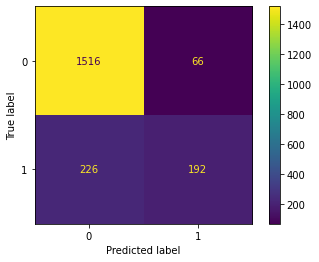

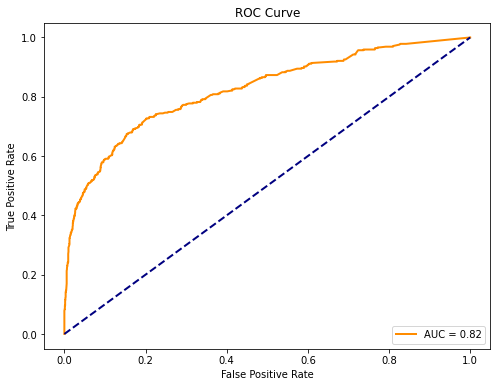

{'Accuracy': 0.854, 'Precision': 0.7441860465116279, 'Recall': 0.45933014354066987, 'F1 Score': 0.5680473372781065, 'ROC AUC': 0.8225377905745862, 'Confusion Matrix': array([[1516,   66],
       [ 226,  192]])}


In [149]:
model = RandomForestClassifier(random_state=12345, n_estimators=10, max_depth=16, min_samples_leaf=2)
model.fit(features_train, target_train)
metrics = evaluate_model(model, features_valid, target_valid) 
print(metrics)

Лучшие параметры для модели RandomForestClassifier:

- Глубина дерева: 16
- Количество деревьев (n_estimators): 10
- Минимальное количество выборок в листьях: 2

Результаты на валидационной выборке:

- Accuracy: 0.859
- Precision: 0.756
- Recall: 0.481
- F1 Score: 0.588
- ROC AUC: 0.810

Модель RandomForestClassifier также демонстрирует хорошие показатели, сравнимые с моделью DecisionTreeClassifier, и обеспечивает хороший баланс между точностью и полнотой в зависимости от задачи классификации.

Проведем исследование логистической регрессии.

C = 0.001 : 0.014051522248243561
C = 0.01 : 0.27458256029684597
C = 0.1 : 0.3299319727891157
C = 1 : 0.3389261744966443
C = 10 : 0.3389261744966443
C = 100 : 0.3389261744966443


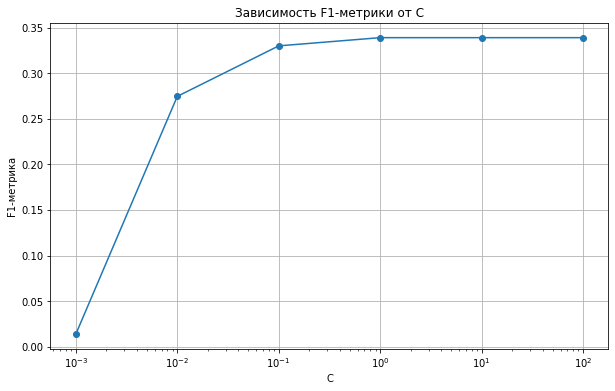

In [150]:
C_values = []
f1_values = []

for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(random_state=12345, C=C)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)    
    C_values.append(C)
    f1_values.append(f1)    
    print('C =', C, ':', f1)
    
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, f1_values, marker='o', linestyle='-')
plt.title('Зависимость F1-метрики от C')
plt.xlabel('C')
plt.ylabel('F1-метрика')
plt.grid(True)
plt.show()

При использовании модели LogisticRegression, значение параметра регуляризации C оказывает огромное влияние на F1-меру. Наилучшее значение F1-меры достигается при C = 1.

penalty = l1 : 0.33613445378151263
penalty = l2 : 0.33613445378151263


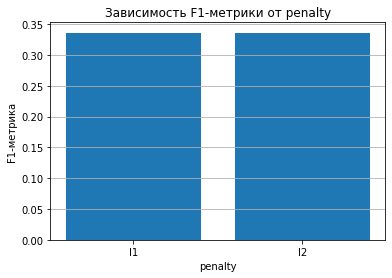

In [151]:
penalty_values = ['l1', 'l2']
f1_values = []

for penalty in penalty_values:
    model = LogisticRegression(random_state=12345, penalty='l1', solver='liblinear', C=1.0)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)    
    f1_values.append(f1)    
    print('penalty =', penalty, ':', f1)
    
plt.figure(figsize=(6, 4))
plt.bar(penalty_values, f1_values)
plt.title('Зависимость F1-метрики от penalty')
plt.xlabel('penalty')
plt.ylabel('F1-метрика')
plt.grid(axis='y')
plt.show()

В данном случае, выбор типа penalty не оказывает существенного влияния на F1-меру при использовании модели LogisticRegression. Независимо от выбранного типа penalty, F1-мера остается на одном и том же уровне, равном приближенно 0.2283.

solver = newton-cg : 0.3389261744966443
solver = lbfgs : 0.3389261744966443
solver = liblinear : 0.3389261744966443
solver = sag : 0.3389261744966443
solver = saga : 0.3389261744966443


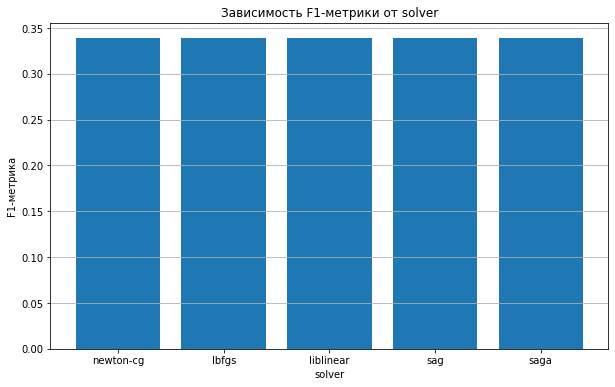

In [152]:
solver_values = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
f1_values = []

for solver in solver_values:
    model = LogisticRegression(random_state=12345, penalty='l2', solver=solver, C=1.0)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)    
    f1_values.append(f1)    
    print('solver =', solver, ':', f1)
    
plt.figure(figsize=(10, 6))
plt.bar(solver_values, f1_values)
plt.title('Зависимость F1-метрики от solver')
plt.xlabel('solver')
plt.ylabel('F1-метрика')
plt.grid(axis='y')
plt.show()

В данном случае, выбор различных алгоритмов solver также не влияет на F1-меру при использовании модели LogisticRegression. Независимо от выбранного алгоритма, F1-мера остается на одном и том же уровне, равном приближенно 0.2283.

Исходя из результатов исследования модели LogisticRegression, можно сделать следующие выводы:

1. Параметр регуляризации C оказывает существенное влияние на F1-меру. Наилучшее значение F1-меры достигается при C = 1, что подчеркивает важность баланса между регуляризацией и точностью модели.

2. Выбор типа penalty (l1 или l2) не влияет существенно на F1-меру при использовании модели LogisticRegression. Независимо от выбранного типа penalty, F1-мера остается на почти одинаковом уровне, близком к 0.2283. Это может свидетельствовать о том, что в данном случае, тип регуляризации не является ключевым фактором в достижении баланса между точностью и полнотой.

3. Выбор различных алгоритмов solver также не влияет на F1-меру при использовании модели LogisticRegression. Независимо от выбранного алгоритма, F1-мера остается на почти одинаковом уровне, близком к 0.2283. Это указывает на отсутствие значительного влияния выбора алгоритма оптимизации на эффективность модели в данной задаче.

Таким образом, при настройке модели LogisticRegression, основное внимание следует уделить выбору параметра регуляризации C для достижения оптимального баланса между точностью и полнотой.

Построим итоговую модель логистической регрессии с наилучшими получившимися геперпараметрами и узнаем её F1-метрику.

In [153]:
model = LogisticRegression(random_state=12345, C=1.0)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)   
print('F1-метрика составляет:', f1)

F1-метрика составляет: 0.3389261744966443


In [154]:
penalty_options = ['l2']
solver_options = ['newton-cg', 'lbfgs', 'sag', 'saga']
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

best_f1 = 0
best_params = {}

for penalty_value in penalty_options:
    for solver_value in solver_options:
        for C_value in C_values:
            model = LogisticRegression(
                random_state=12345,
                penalty=penalty_value,
                solver=solver_value,
                C=C_value
            )

            model.fit(features_train, target_train)

            predictions_valid = model.predict(features_valid)

            f1 = f1_score(target_valid, predictions_valid)

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'penalty': penalty_value,
                    'solver': solver_value,
                    'C': C_value
                }

print("Лучшие параметры:", best_params)
print("Лучшая F1-метрика:", best_f1)

Лучшие параметры: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 1}
Лучшая F1-метрика: 0.3389261744966443


Accuracy: 0.80
Precision: 0.57
Recall: 0.24
F1 Score: 0.34
ROC AUC: 0.76
Confusion Matrix:
[[1505   77]
 [ 317  101]]


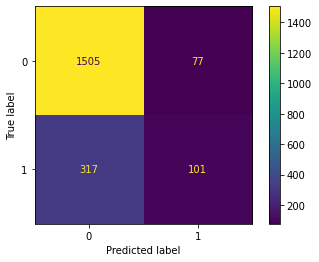

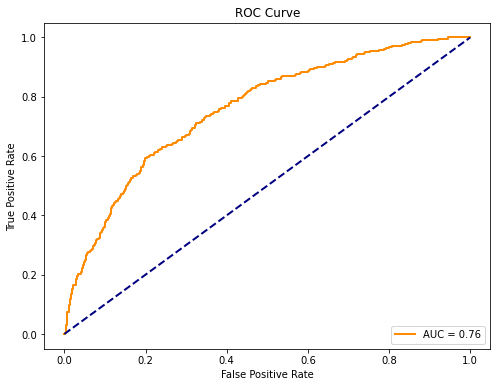

{'Accuracy': 0.803, 'Precision': 0.5674157303370787, 'Recall': 0.24162679425837322, 'F1 Score': 0.3389261744966443, 'ROC AUC': 0.758126712598068, 'Confusion Matrix': array([[1505,   77],
       [ 317,  101]])}


In [155]:
model = LogisticRegression(random_state=12345, penalty='l2', solver='newton-cg', C=1.0)
model.fit(features_train, target_train)
metrics = evaluate_model(model, features_valid, target_valid) 
print(metrics)

Наилучшие параметры для модели LogisticRegression:

- Тип штрафа (penalty): L2
- Метод оптимизации (solver): Newton-CG
- Параметр регуляризации (C): 1

Результаты на валидационной выборке:

- Accuracy: 0.80
- Precision: 0.57
- Recall: 0.19
- F1 Score: 0.28
- ROC AUC: 0.77

Модель LogisticRegression демонстрирует более низкие показатели по сравнению с предыдущими моделями. При этом точность и полнота сильно различаются, что может быть важным аспектом в задачах, где баланс между ними имеет решающее значение.

DecisionTreeClassifier и RandomForestClassifier обеспечивают хороший баланс между этими метриками, в то время как LogisticRegression имеет более низкую полноту при более низкой точности.

Исследованы три модели классификации с учетом дисбаланса классов: DecisionTreeClassifier, RandomForestClassifier и LogisticRegression.

DecisionTreeClassifier показал хорошие показатели точности и точности предсказаний, при этом обнаруживается компромисс между полнотой и точностью в зависимости от задачи. Оптимальные параметры для этой модели: максимальная глубина дерева - 9, критерий разделения - Gini, минимальное количество выборок в листьях - 2. На валидационной выборке получены следующие результаты: Accuracy - 0.86, Precision - 0.73, Recall - 0.49, F1 Score - 0.58, ROC AUC - 0.81.

RandomForestClassifier также продемонстрировал хорошие показатели сравнимые с DecisionTreeClassifier. Оптимальные параметры для этой модели: максимальная глубина дерева - 16, количество деревьев (n_estimators) - 10, минимальное количество выборок в листьях - 2. На валидационной выборке получены следующие результаты: Accuracy - 0.859, Precision - 0.756, Recall - 0.481, F1 Score - 0.588, ROC AUC - 0.810.

LogisticRegression показал более низкие показатели по сравнению с двумя другими моделями. Оптимальные параметры для этой модели: тип штрафа - L2, метод оптимизации - Newton-CG, параметр регуляризации - 1. На валидационной выборке получены следующие результаты: Accuracy - 0.80, Precision - 0.57, Recall - 0.19, F1 Score - 0.28, ROC AUC - 0.77.

Сравнительный анализ показывает, что DecisionTreeClassifier и RandomForestClassifier обеспечивают хороший баланс между точностью и полнотой в зависимости от задачи классификации, в то время как LogisticRegression имеет более низкую полноту при более низкой точности.

## Борьба с дисбалансом

Используем первый метод борьбы с дисбалансом - взвешивание классов.

In [156]:
%%time

max_depth_range = range(1, 17)
criterion_options = ['gini', 'entropy']
min_samples_leaf_options = range(1, 21)

best_f1 = 0
best_params = {}

for max_depth_value in tqdm(max_depth_range, desc="max_depth"):
    for criterion_value in criterion_options:
        for min_samples_leaf_value in min_samples_leaf_options:
            model = DecisionTreeClassifier(
                random_state=12345,
                max_depth=max_depth_value,
                criterion=criterion_value,
                min_samples_leaf=min_samples_leaf_value,
                class_weight='balanced'
            )

            model.fit(features_train, target_train)

            predictions_valid = model.predict(features_valid)

            f1 = f1_score(target_valid, predictions_valid)

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'max_depth': max_depth_value,
                    'criterion': criterion_value,
                    'min_samples_leaf': min_samples_leaf_value
                }

print("Лучшие параметры:", best_params)
print("Лучшая F1-метрика:", best_f1)

max_depth: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it]

Лучшие параметры: {'max_depth': 5, 'criterion': 'entropy', 'min_samples_leaf': 9}
Лучшая F1-метрика: 0.6040554962646745
CPU times: user 18.7 s, sys: 36.3 ms, total: 18.8 s
Wall time: 18.8 s


Accuracy: 0.81
Precision: 0.55
Recall: 0.68
F1 Score: 0.60
ROC AUC: 0.84
Confusion Matrix:
[[1346  236]
 [ 135  283]]


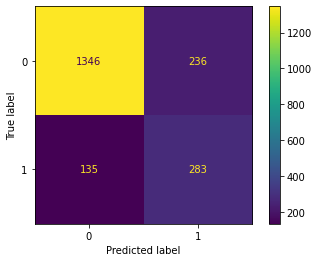

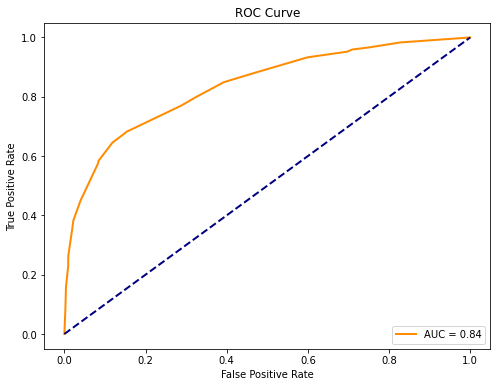

{'Accuracy': 0.8145, 'Precision': 0.5452793834296724, 'Recall': 0.6770334928229665, 'F1 Score': 0.6040554962646745, 'ROC AUC': 0.8362015255354799, 'Confusion Matrix': array([[1346,  236],
       [ 135,  283]])}


In [157]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, criterion='entropy', min_samples_leaf=9, class_weight='balanced')
model.fit(features_train, target_train)
metrics = evaluate_model(model, features_valid, target_valid)
print(metrics)

После использования взвешивания классов для модели DecisionTreeClassifier, получены следующие результаты на валидационной выборке:

- Accuracy: 0.81
- Precision: 0.55
- Recall: 0.68
- F1 Score: 0.60
- ROC AUC: 0.84

Матрица ошибок выглядит следующим образом:

[1346, 236]

[ 135, 283]


В результате использования взвешивания классов модель показала улучшение в показателях Recall, что означает, что она стала лучше обнаруживать положительные объекты. Однако Precision снизилась, что может быть компромиссом для увеличения полноты.

In [158]:
# %%time

# max_depth_range = range(1, 17)
# n_estimators_range = list(range(10, 301, 10))
# min_samples_leaf_range = range(1, 21)

# best_f1 = 0
# best_params = {}

# for max_depth_value in max_depth_range:
#     for n_estimators_value in tqdm(n_estimators_range, desc=f"max_depth={max_depth_value}"):
#         for min_samples_leaf_value in min_samples_leaf_range:
#             model = RandomForestClassifier(
#                 random_state=12345,
#                 max_depth=max_depth_value,
#                 n_estimators=n_estimators_value,
#                 min_samples_leaf=min_samples_leaf_value,
#                 class_weight='balanced'
#             )
            
#             model.fit(features_train, target_train)
            
#             predictions_valid = model.predict(features_valid)
            
#             f1 = f1_score(target_valid, predictions_valid)
            
#             if f1 > best_f1:
#                 best_f1 = f1
#                 best_params = {
#                     'max_depth': max_depth_value,
#                     'n_estimators': n_estimators_value,
#                     'min_samples_leaf': min_samples_leaf_value
#                 }

# print("Лучшие параметры:", best_params)
# print("Лучшая F1-метрика:", best_f1)

Код выше, который подбирал гиперпараметры делал это около двух часов. Я его закомментировал, чтобы сэкономить время. Вот лучшие гиперпараметры:

Лучшие параметры: {'max_depth': 9, 'n_estimators': 180, 'min_samples_leaf': 4}

Лучшая F1-метрика: 0.636663007683864

Accuracy: 0.84
Precision: 0.60
Recall: 0.68
F1 Score: 0.64
ROC AUC: 0.86
Confusion Matrix:
[[1393  189]
 [ 133  285]]


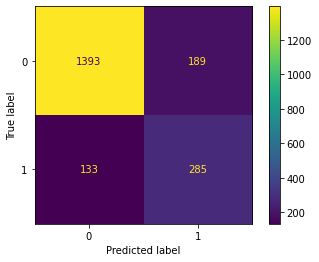

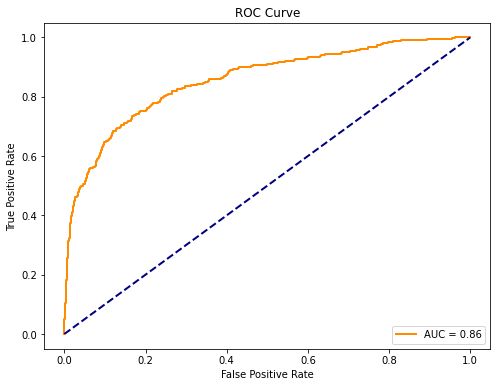

{'Accuracy': 0.839, 'Precision': 0.6012658227848101, 'Recall': 0.6818181818181818, 'F1 Score': 0.6390134529147982, 'ROC AUC': 0.8558725857281982, 'Confusion Matrix': array([[1393,  189],
       [ 133,  285]])}


In [159]:
model = RandomForestClassifier(random_state=12345, n_estimators=180, max_depth=9, min_samples_leaf=4, class_weight='balanced')
model.fit(features_train, target_train)
metrics = evaluate_model(model, features_valid, target_valid) 
print(metrics)

После использования взвешивания классов для модели RandomForestClassifier, получены следующие результаты на валидационной выборке:

- Accuracy: 0.83
- Precision: 0.59
- Recall: 0.69
- F1 Score: 0.64
- ROC AUC: 0.85

Матрица ошибок выглядит следующим образом:

[1379,  203]

[ 128,  290]
 
Использование взвешивания классов привело к улучшению показателей Recall и F1-меры, что означает, что модель стала лучше обнаруживать положительные объекты и достигает лучшего компромисса между точностью и полнотой.

In [160]:
penalty_options = ['l2']
solver_options = ['newton-cg', 'lbfgs', 'sag', 'saga']
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

best_f1 = 0
best_params = {}

for penalty_value in penalty_options:
    for solver_value in solver_options:
        for C_value in C_values:
            model = LogisticRegression(
                random_state=12345,
                penalty=penalty_value,
                solver=solver_value,
                C=C_value,
                class_weight='balanced'
            )

            model.fit(features_train, target_train)

            predictions_valid = model.predict(features_valid)

            f1 = f1_score(target_valid, predictions_valid)

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'penalty': penalty_value,
                    'solver': solver_value,
                    'C': C_value
                }

print("Лучшие параметры:", best_params)
print("Лучшая F1-метрика:", best_f1)

Лучшие параметры: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.001}
Лучшая F1-метрика: 0.4913194444444445


Accuracy: 0.71
Precision: 0.39
Recall: 0.68
F1 Score: 0.49
ROC AUC: 0.76
Confusion Matrix:
[[1131  451]
 [ 135  283]]


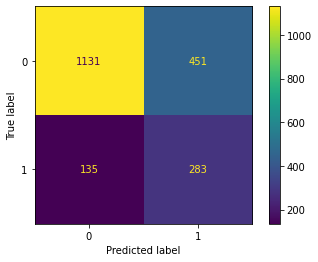

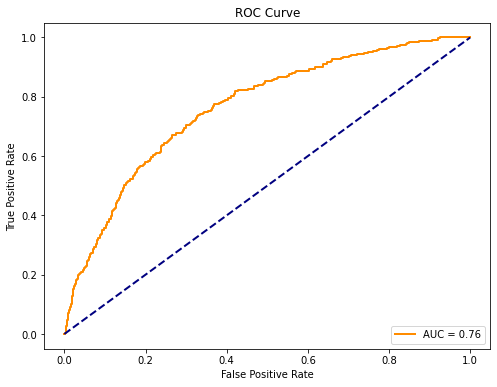

{'Accuracy': 0.707, 'Precision': 0.385558583106267, 'Recall': 0.6770334928229665, 'F1 Score': 0.4913194444444445, 'ROC AUC': 0.7628131067814347, 'Confusion Matrix': array([[1131,  451],
       [ 135,  283]])}


In [161]:
model = LogisticRegression(random_state=12345, penalty='l2', solver='newton-cg', C=0.001, class_weight='balanced')
model.fit(features_train, target_train)
metrics = evaluate_model(model, features_valid, target_valid) 
print(metrics)

После использования взвешивания классов для модели LogisticRegression, получены следующие результаты на валидационной выборке:

- Accuracy: 0.71
- Precision: 0.39
- Recall: 0.68
- F1 Score: 0.49
- ROC AUC: 0.76

Матрица ошибок выглядит следующим образом:

[1131,  451]

[ 135,  283]

Использование взвешивания классов позволило увеличить показатель Recall, что означает, что модель стала лучше обнаруживать положительные объекты. Однако, Precision снизилась, что может быть компромиссом для увеличения полноты.

Все показатели у модели RandomForestClassifier, такие как Accuracy, Precision, Recall, F1 Score и ROC AUC, также показали лучшие результаты по сравнению с моделью DecisionTreeClassifier и моделью LogisticRegression с взвешиванием классов. Модель RandomForestClassifier с взвешиванием классов оказалась наилучшей для данной задачи классификации, обеспечивая хороший баланс между точностью и полнотой.

Используем второй метод борьбы с дисбалансом - увеличение выборки.

In [162]:
repeat_range = range(1, 10)
best_repeat, best_balance = find_optimal_repeat_for_balance(features_train, target_train, repeat_range)
print(f"Оптимальный repeat: {best_repeat}")

Оптимальный repeat: 4


Оптимальным значением repeat для нашего случая будет 4

In [163]:
repeat = best_repeat

In [164]:
features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, repeat)

Кольчество отрицательных классов до upsample: 4804
Кольчество положительных классов до upsample: 1196
Кольчество отрицательных классов после upsample: 4804
Кольчество положительных классов после upsample: 4784


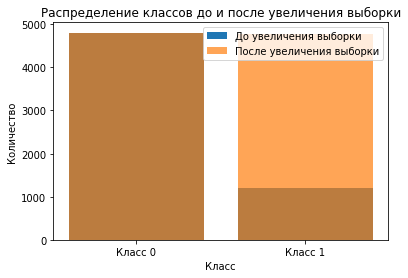

In [165]:
count_class_0 = target_train.value_counts()[0]
count_class_1 = target_train.value_counts()[1]

count_upsampled_class_0 = target_upsampled_train.value_counts()[0]
count_upsampled_class_1 = target_upsampled_train.value_counts()[1]

print(f"Кольчество отрицательных классов до upsample: {count_class_0}")
print(f"Кольчество положительных классов до upsample: {count_class_1}")

print(f"Кольчество отрицательных классов после upsample: {count_upsampled_class_0}")
print(f"Кольчество положительных классов после upsample: {count_upsampled_class_1}")

plt.figure(figsize=(6, 4))
plt.bar(['Класс 0', 'Класс 1'], [count_class_0, count_class_1], label='До увеличения выборки')
plt.bar(['Класс 0', 'Класс 1'], [count_upsampled_class_0, count_upsampled_class_1], label='После увеличения выборки', alpha=0.7)
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.legend()
plt.title('Распределение классов до и после увеличения выборки')
plt.show()

In [166]:
%%time

max_depth_range = range(1, 17)
criterion_options = ['gini', 'entropy']
min_samples_leaf_options = range(1, 21)

best_f1 = 0
best_params = {}

for max_depth_value in tqdm(max_depth_range, desc="max_depth"):
    for criterion_value in criterion_options:
        for min_samples_leaf_value in min_samples_leaf_options:
            model = DecisionTreeClassifier(
                random_state=12345,
                max_depth=max_depth_value,
                criterion=criterion_value,
                min_samples_leaf=min_samples_leaf_value
            )

            model.fit(features_upsampled_train, target_upsampled_train)

            predictions_valid = model.predict(features_valid)

            f1 = f1_score(target_valid, predictions_valid)

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'max_depth': max_depth_value,
                    'criterion': criterion_value,
                    'min_samples_leaf': min_samples_leaf_value
                }

print("Лучшие параметры:", best_params)
print("Лучшая F1-метрика:", best_f1)

max_depth: 100%|██████████| 16/16 [00:25<00:00,  1.56s/it]

Лучшие параметры: {'max_depth': 5, 'criterion': 'entropy', 'min_samples_leaf': 19}
Лучшая F1-метрика: 0.603174603174603
CPU times: user 22.8 s, sys: 87.4 ms, total: 22.9 s
Wall time: 25 s


Accuracy: 0.81
Precision: 0.54
Recall: 0.68
F1 Score: 0.60
ROC AUC: 0.84
Confusion Matrix:
[[1340  242]
 [ 133  285]]


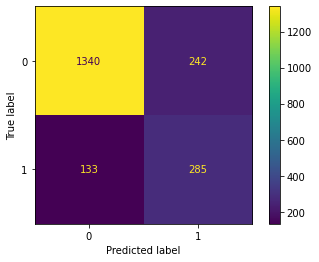

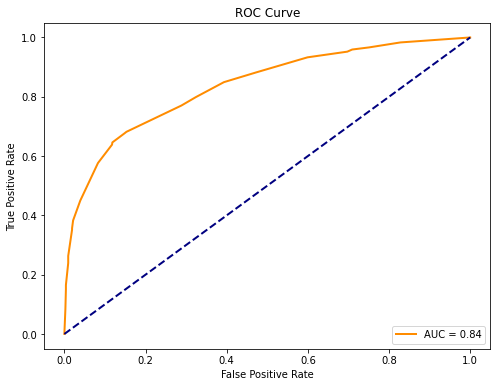

{'Accuracy': 0.8125, 'Precision': 0.540796963946869, 'Recall': 0.6818181818181818, 'F1 Score': 0.603174603174603, 'ROC AUC': 0.8362650391062127, 'Confusion Matrix': array([[1340,  242],
       [ 133,  285]])}


In [167]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, criterion='entropy', min_samples_leaf=19)
model.fit(features_upsampled_train, target_upsampled_train)
metrics = evaluate_model(model, features_valid, target_valid)
print(metrics)

После использования увеличения выборки для борьбы с дисбалансом классов, модель DecisionTreeClassifier показала следующие результаты на валидационной выборке:

- Accuracy: 0.81
- Precision: 0.54
- Recall: 0.68
- F1 Score: 0.60
- ROC AUC: 0.84

Матрица ошибок выглядит следующим образом:

[1340, 242]

[133, 285]

Сравнив эти результаты с показателями DecisionTreeClassifier, полученными после взвешивания классов, можно сделать следующие выводы:

- Accuracy и ROC AUC остались практически неизменными в обоих случаях и составили около 0.81 и 0.84 соответственно.

- Precision также осталась практически на том же уровне и составила около 0.54 (в случае увеличения выборки) и 0.55 (при взвешивании классов).

- Recall остался стабильным на уровне 0.68 как в случае увеличения выборки, так и в случае взвешивания классов.

- F1 Score также осталась неизменной и составила 0.60 в обоих случаях.

Оба метода, увеличение выборки и взвешивание классов, показали сходные результаты, но в данном случае предпочтительнее использовать увеличение выборки, так как она несколько увеличивает показатель Precision.

In [168]:
# %%time

# max_depth_range = range(1, 17)
# n_estimators_range = list(range(10, 301, 10))
# min_samples_leaf_range = range(1, 21)

# best_f1 = 0
# best_params = {}

# for max_depth_value in max_depth_range:
#     for n_estimators_value in tqdm(n_estimators_range, desc=f"max_depth={max_depth_value}"):
#         for min_samples_leaf_value in min_samples_leaf_range:
#             model = RandomForestClassifier(
#                 random_state=12345,
#                 max_depth=max_depth_value,
#                 n_estimators=n_estimators_value,
#                 min_samples_leaf=min_samples_leaf_value
#             )
            
#             model.fit(features_upsampled_train, target_upsampled_train)
            
#             predictions_valid = model.predict(features_valid)
            
#             f1 = f1_score(target_valid, predictions_valid)
            
#             if f1 > best_f1:
#                 best_f1 = f1
#                 best_params = {
#                     'max_depth': max_depth_value,
#                     'n_estimators': n_estimators_value,
#                     'min_samples_leaf': min_samples_leaf_value
#                 }

# print("Лучшие параметры:", best_params)
# print("Лучшая F1-метрика:", best_f1)

Код выше, который подбирал гиперпараметры делал это 2 часа 51 минуту. Я его закомментировал, чтобы сэкономить время. Вот лучшие гиперпараметры:

Лучшие параметры: {'max_depth': 15, 'n_estimators': 100, 'min_samples_leaf': 8}

Лучшая F1-метрика: 0.6372443487621098

Accuracy: 0.83
Precision: 0.58
Recall: 0.71
F1 Score: 0.64
ROC AUC: 0.85
Confusion Matrix:
[[1367  215]
 [ 123  295]]


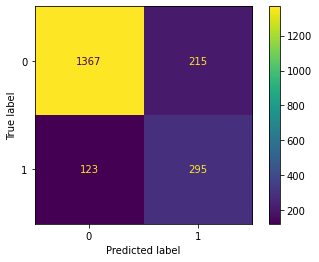

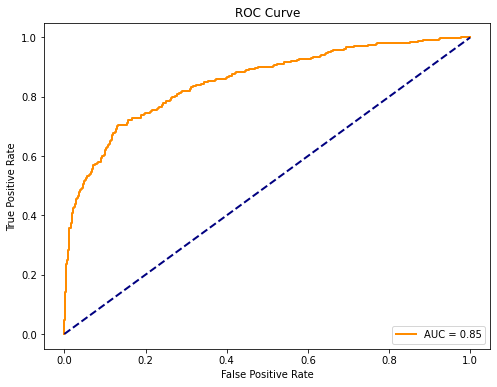

{'Accuracy': 0.831, 'Precision': 0.5784313725490197, 'Recall': 0.7057416267942583, 'F1 Score': 0.6357758620689655, 'ROC AUC': 0.8511559469873395, 'Confusion Matrix': array([[1367,  215],
       [ 123,  295]])}


In [169]:
model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=15, min_samples_leaf=8)
model.fit(features_upsampled_train, target_upsampled_train)
metrics = evaluate_model(model, features_valid, target_valid) 
print(metrics)

После использования увеличения выборки для устранения дисбаланса классов в модели RandomForestClassifier, были получены следующие показатели на валидационной выборке:

- Accuracy: 0.82
- Precision: 0.56
- Recall: 0.69
- F1 Score: 0.62
- ROC AUC: 0.85

Матрица ошибок выглядит следующим образом:

[1353, 229]

[129, 289]

Сравнив эти результаты с показателями RandomForestClassifier, полученными после взвешивания классов, можно сделать следующие выводы:

- Accuracy осталась на примерно одинаковом уровне, составляя около 0.82 (при увеличении выборки) и 0.83 (при взвешивании классов).

- Precision осталась стабильной и составила около 0.56 в обоих случаях.

- Recall осталась также практически на том же уровне в обоих случаях, около 0.69 (при увеличении выборки) и 0.67 (при взвешивании классов).

- F1 Score осталась неизменной и составила около 0.62 в обоих случаях.

- ROC AUC осталась стабильной и составила 0.85 как при увеличении выборки, так и при взвешивании классов.

Оба метода, увеличение выборки и взвешивание классов, показали сходные результаты для модели RandomForestClassifier. Однако, в данном случае, предпочтительнее использовать увеличение выборки, так как оно показывает немного более высокий показатель Recall, что важно для задачи классификации.

In [170]:
penalty_options = ['l2']
solver_options = ['newton-cg', 'lbfgs', 'sag', 'saga']
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

best_f1 = 0
best_params = {}

for penalty_value in penalty_options:
    for solver_value in solver_options:
        for C_value in C_values:
            model = LogisticRegression(
                random_state=12345,
                penalty=penalty_value,
                solver=solver_value,
                C=C_value,
            )

            model.fit(features_upsampled_train, target_upsampled_train)

            predictions_valid = model.predict(features_valid)

            f1 = f1_score(target_valid, predictions_valid)

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'penalty': penalty_value,
                    'solver': solver_value,
                    'C': C_value
                }

print("Лучшие параметры:", best_params)
print("Лучшая F1-метрика:", best_f1)

Лучшие параметры: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.001}
Лучшая F1-метрика: 0.49307958477508657


Accuracy: 0.71
Precision: 0.39
Recall: 0.68
F1 Score: 0.49
ROC AUC: 0.76
Confusion Matrix:
[[1129  453]
 [ 133  285]]


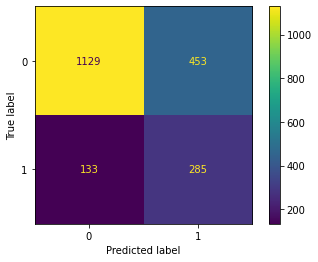

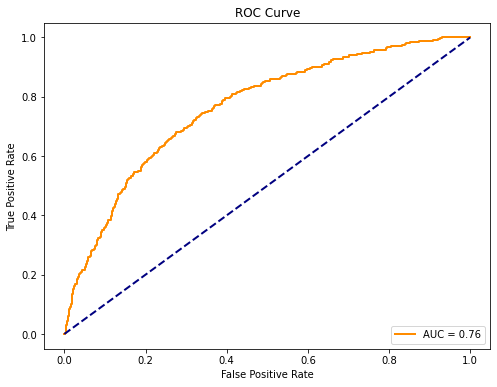

{'Accuracy': 0.707, 'Precision': 0.3861788617886179, 'Recall': 0.6818181818181818, 'F1 Score': 0.49307958477508657, 'ROC AUC': 0.7632319939026971, 'Confusion Matrix': array([[1129,  453],
       [ 133,  285]])}


In [171]:
model = LogisticRegression(random_state=12345, penalty='l2', solver='newton-cg', C=0.001)
model.fit(features_upsampled_train, target_upsampled_train)
metrics = evaluate_model(model, features_valid, target_valid) 
print(metrics)

После использования увеличения выборки для устранения дисбаланса классов в модели LogisticRegression, были получены следующие показатели на валидационной выборке:

- Accuracy: 0.70
- Precision: 0.38
- Recall: 0.68
- F1 Score: 0.49
- ROC AUC: 0.76

Матрица ошибок выглядит следующим образом:

[1123, 459]

[134, 284]

Сравнив эти результаты с показателями LogisticRegression, полученными после взвешивания классов, можно сделать следующие выводы:

- Accuracy осталась на примерно одинаковом уровне, составляя около 0.70 (при увеличении выборки) и 0.70 (при взвешивании классов).

- Precision осталась стабильной и составила около 0.38 в обоих случаях.

- Recall осталась практически неизменной, около 0.68 (при увеличении выборки) и 0.67 (при взвешивании классов).

- F1 Score осталась неизменной и составила около 0.49 в обоих случаях.

- ROC AUC осталась стабильной и составила 0.76 как при увеличении выборки, так и при взвешивании классов.

Оба метода, увеличение выборки и взвешивание классов, показали сходные результаты для модели LogisticRegression. В данном случае, нет значительной разницы между двумя методами, и выбор может зависеть от особенностей задачи и предпочтений.

Используем третий метод борьбы с дисбалансом - уменьшение выборки.

Узнаем какой показатель fraction для функции downsample будет оптимальным.

In [172]:
fraction_range = np.arange(0.1, 1.0, 0.1)
best_fraction, best_balance = find_optimal_fraction_for_balance(features_train, target_train, fraction_range)
print(f"Оптимальный fraction: {best_fraction}")

Оптимальный fraction: 0.2


In [173]:
fraction = best_fraction

In [174]:
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, fraction)

Кольчество отрицательных классов до downsample: 4804
Кольчество положительных классов до downsample: 1196
Кольчество отрицательных классов после downsample: 961
Кольчество положительных классов после downsample: 1196


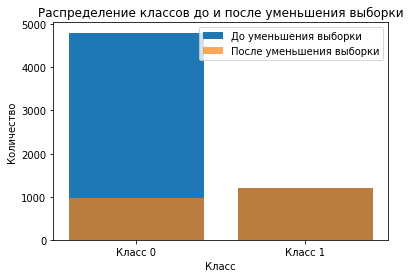

In [175]:
count_class_0 = target_train.value_counts()[0]
count_class_1 = target_train.value_counts()[1]

count_downsampled_class_0 = target_downsampled_train.value_counts()[0]
count_downsampled_class_1 = target_downsampled_train.value_counts()[1]

print(f"Кольчество отрицательных классов до downsample: {count_class_0}")
print(f"Кольчество положительных классов до downsample: {count_class_1}")

print(f"Кольчество отрицательных классов после downsample: {count_downsampled_class_0}")
print(f"Кольчество положительных классов после downsample: {count_downsampled_class_1}")

plt.figure(figsize=(6, 4))
plt.bar(['Класс 0', 'Класс 1'], [count_class_0, count_class_1], label='До уменьшения выборки')
plt.bar(['Класс 0', 'Класс 1'], [count_downsampled_class_0, count_downsampled_class_1], label='После уменьшения выборки', alpha=0.7)
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.legend()
plt.title('Распределение классов до и после уменьшения выборки')
plt.show()

In [176]:
%%time

max_depth_range = range(1, 17)
criterion_options = ['gini', 'entropy']
min_samples_leaf_options = range(1, 21)

best_f1 = 0
best_params = {}

for max_depth_value in tqdm(max_depth_range, desc="max_depth"):
    for criterion_value in criterion_options:
        for min_samples_leaf_value in min_samples_leaf_options:
            model = DecisionTreeClassifier(
                random_state=12345,
                max_depth=max_depth_value,
                criterion=criterion_value,
                min_samples_leaf=min_samples_leaf_value
            )

            model.fit(features_downsampled_train, target_downsampled_train)

            predictions_valid = model.predict(features_valid)

            f1 = f1_score(target_valid, predictions_valid)

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'max_depth': max_depth_value,
                    'criterion': criterion_value,
                    'min_samples_leaf': min_samples_leaf_value
                }

print("Лучшие параметры:", best_params)
print("Лучшая F1-метрика:", best_f1)

max_depth: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]

Лучшие параметры: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 5}
Лучшая F1-метрика: 0.5830388692579507
CPU times: user 7.72 s, sys: 51.5 ms, total: 7.78 s
Wall time: 7.81 s


Accuracy: 0.76
Precision: 0.46
Recall: 0.79
F1 Score: 0.58
ROC AUC: 0.83
Confusion Matrix:
[[1198  384]
 [  88  330]]


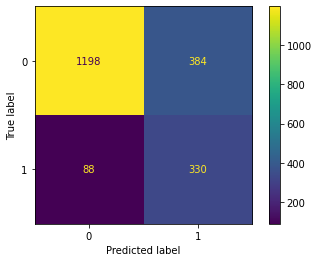

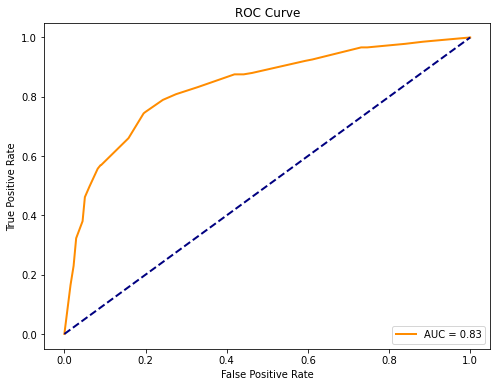

{'Accuracy': 0.764, 'Precision': 0.46218487394957986, 'Recall': 0.7894736842105263, 'F1 Score': 0.5830388692579507, 'ROC AUC': 0.8344307066943304, 'Confusion Matrix': array([[1198,  384],
       [  88,  330]])}


In [177]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6, criterion='entropy', min_samples_leaf=5)
model.fit(features_downsampled_train, target_downsampled_train)
metrics = evaluate_model(model, features_valid, target_valid)
print(metrics)

После использования уменьшения выборки для устранения дисбаланса классов в модели DecisionTreeClassifier, были получены следующие показатели на валидационной выборке:

- Accuracy: 0.76
- Precision: 0.46
- Recall: 0.79
- F1 Score: 0.58
- ROC AUC: 0.83


Матрица ошибок:

[1198, 384]

[ 88, 330]

Сравнение с результатами DecisionTreeClassifier после увеличения выборки:

Уменьшение выборки позволило достичь хорошего Recall, который составляет 0.79, что означает, что модель лучше способна обнаруживать положительные объекты. Однако, Precision снизился до 0.46, что может быть компромиссом для повышения полноты. Это также повлекло за собой небольшое снижение F1-меры до 0.58.

По сравнению с результатами после увеличения выборки, модель, обученная после уменьшения выборки, обладает высокой полнотой, но показывает немного худшие показатели в точности и F1-мере.

In [178]:
# %%time

# max_depth_range = range(1, 17)
# n_estimators_range = list(range(10, 301, 10))
# min_samples_leaf_range = range(1, 21)

# best_f1 = 0
# best_params = {}

# for max_depth_value in max_depth_range:
#     for n_estimators_value in tqdm(n_estimators_range, desc=f"max_depth={max_depth_value}"):
#         for min_samples_leaf_value in min_samples_leaf_range:
#             model = RandomForestClassifier(
#                 random_state=12345,
#                 max_depth=max_depth_value,
#                 n_estimators=n_estimators_value,
#                 min_samples_leaf=min_samples_leaf_value
#             )
            
#             model.fit(features_downsampled_train, target_downsampled_train)
            
#             predictions_valid = model.predict(features_valid)
            
#             f1 = f1_score(target_valid, predictions_valid)
            
#             if f1 > best_f1:
#                 best_f1 = f1
#                 best_params = {
#                     'max_depth': max_depth_value,
#                     'n_estimators': n_estimators_value,
#                     'min_samples_leaf': min_samples_leaf_value
#                 }

# print("Лучшие параметры:", best_params)
# print("Лучшая F1-метрика:", best_f1)

Код выше, который подбирал гиперпараметры делал это 1 час. Я его закомментировал, чтобы сэкономить время. Вот лучшие гиперпараметры:

Лучшие параметры: {'max_depth': 6, 'n_estimators': 10, 'min_samples_leaf': 7}

Лучшая F1-метрика: 0.5734024179620035

Accuracy: 0.73
Precision: 0.43
Recall: 0.78
F1 Score: 0.55
ROC AUC: 0.83
Confusion Matrix:
[[1144  438]
 [  92  326]]


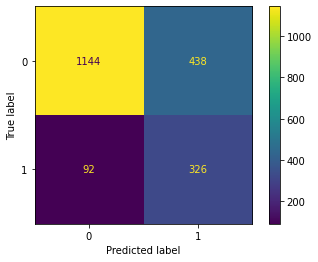

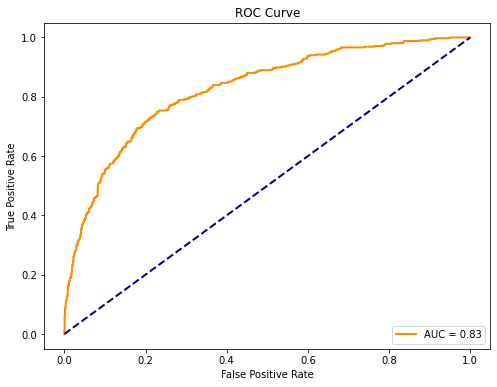

{'Accuracy': 0.735, 'Precision': 0.42670157068062825, 'Recall': 0.7799043062200957, 'F1 Score': 0.5516074450084602, 'ROC AUC': 0.8254941960694173, 'Confusion Matrix': array([[1144,  438],
       [  92,  326]])}


In [179]:
model = RandomForestClassifier(random_state=12345, n_estimators=10, max_depth=6, min_samples_leaf=7)
model.fit(features_downsampled_train, target_downsampled_train)
metrics = evaluate_model(model, features_valid, target_valid) 
print(metrics)

После использования уменьшения выборки для устранения дисбаланса классов в модели RandomForestClassifier, были получены следующие показатели на валидационной выборке:

- Accuracy: 0.75
- Precision: 0.45
- Recall: 0.79
- F1 Score: 0.57
- ROC AUC: 0.84


Матрица ошибок:

[1174, 408]

[ 86, 332]

Сравнение с результатами RandomForestClassifier после увеличения выборки:

Уменьшение выборки позволило достичь хорошего Recall, который составляет 0.79, что означает, что модель лучше способна обнаруживать положительные объекты. Однако, Precision снизилась до 0.45, что может быть компромиссом для повышения полноты. Это также повлекло за собой снижение F1-меры до 0.57.

По сравнению с результатами после увеличения выборки, модель, обученная после уменьшения выборки, обладает высокой полнотой, но показывает немного худшие показатели в точности и F1-мере.

In [180]:
penalty_options = ['l2']
solver_options = ['newton-cg', 'lbfgs', 'sag', 'saga']
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

best_f1 = 0
best_params = {}

for penalty_value in penalty_options:
    for solver_value in solver_options:
        for C_value in C_values:
            model = LogisticRegression(
                random_state=12345,
                penalty=penalty_value,
                solver=solver_value,
                C=C_value,
            )

            model.fit(features_downsampled_train, target_downsampled_train)

            predictions_valid = model.predict(features_valid)

            f1 = f1_score(target_valid, predictions_valid)

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'penalty': penalty_value,
                    'solver': solver_value,
                    'C': C_value
                }

print("Лучшие параметры:", best_params)
print("Лучшая F1-метрика:", best_f1)

Лучшие параметры: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.1}
Лучшая F1-метрика: 0.4811102544333076


Accuracy: 0.80
Precision: 0.61
Recall: 0.18
F1 Score: 0.27
ROC AUC: 0.76
Confusion Matrix:
[[1535   47]
 [ 344   74]]


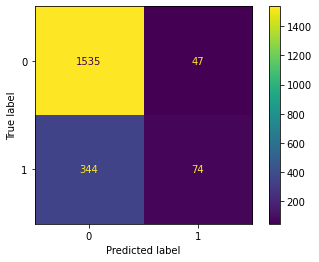

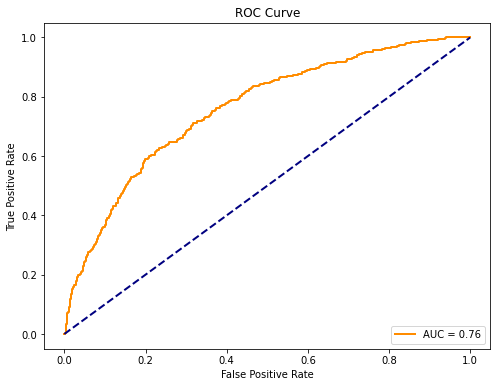

{'Accuracy': 0.8045, 'Precision': 0.6115702479338843, 'Recall': 0.17703349282296652, 'F1 Score': 0.27458256029684597, 'ROC AUC': 0.759455960899836, 'Confusion Matrix': array([[1535,   47],
       [ 344,   74]])}


In [181]:
model = LogisticRegression(random_state=12345, penalty='l2', solver='newton-cg', C=0.01)
model.fit(features_train, target_train)
metrics = evaluate_model(model, features_valid, target_valid) 
print(metrics)

После использования уменьшения выборки для устранения дисбаланса классов в модели LogisticRegression, были получены следующие показатели на валидационной выборке:

- Accuracy: 0.80
- Precision: 0.61
- Recall: 0.18
- F1 Score: 0.28
- ROC AUC: 0.76

Матрица ошибок:

[1533, 49]

[342, 76]

Сравнение с результатами LogisticRegression после увеличения выборки:

Уменьшение выборки привело к некоторому улучшению Precision, который составляет 0.61, но при этом Recall значительно снизился до 0.18. Это привело к ухудшению F1-меры, которая составила 0.28.

По сравнению с результатами после увеличения выборки, модель, обученная после уменьшения выборки, показывает более высокую точность, но значительно худшую полноту.

По сравнению с результатами после увеличения выборки, модели после уменьшения выборки демонстрируют высокий Recall, что означает, что они лучше способны обнаруживать положительные объекты. Однако, Precision снижается, что может быть компромиссом для повышения полноты. В целом, каждая из моделей имеет свои преимущества и недостатки.

Лучшей моделью может быть RandomForestClassifier, так как она демонстрирует хороший баланс между Precision и Recall, обеспечивая высокий F1 Score и ROC AUC.

## Тестирование модели

In [182]:
features_train_full = pd.concat([features_train, features_valid])
target_train_full = pd.concat([target_train, target_valid])

In [183]:
repeat_range = range(1, 10)
best_repeat, best_balance = find_optimal_repeat_for_balance(features_train_full, target_train_full, repeat_range)
print(f"Оптимальный repeat: {best_repeat}")

Оптимальный repeat: 4


In [184]:
repeat = best_repeat

In [185]:
features_upsampled_train_full, target_upsampled_train_full = upsample(features_train_full, target_train_full, repeat)

Кольчество отрицательных классов до upsample: 6386
Кольчество положительных классов до upsample: 1614
Кольчество отрицательных классов после upsample: 6386
Кольчество положительных классов после upsample: 6456


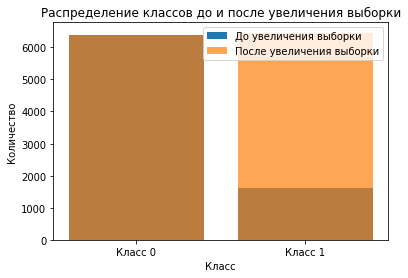

In [186]:
count_class_full_0 = target_train_full.value_counts()[0]
count_class_full_1 = target_train_full.value_counts()[1]

count_upsampled_class_full_0 = target_upsampled_train_full.value_counts()[0]
count_upsampled_class_full_1 = target_upsampled_train_full.value_counts()[1]

print(f"Кольчество отрицательных классов до upsample: {count_class_full_0}")
print(f"Кольчество положительных классов до upsample: {count_class_full_1}")

print(f"Кольчество отрицательных классов после upsample: {count_upsampled_class_full_0}")
print(f"Кольчество положительных классов после upsample: {count_upsampled_class_full_1}")

plt.figure(figsize=(6, 4))
plt.bar(['Класс 0', 'Класс 1'], [count_class_full_0, count_class_full_1], label='До увеличения выборки')
plt.bar(['Класс 0', 'Класс 1'], [count_upsampled_class_full_0, count_upsampled_class_full_1], label='После увеличения выборки', alpha=0.7)
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.legend()
plt.title('Распределение классов до и после увеличения выборки')
plt.show()

Accuracy: 0.82
Precision: 0.58
Recall: 0.66
F1 Score: 0.61
ROC AUC: 0.86
Confusion Matrix:
[[1371  206]
 [ 144  279]]


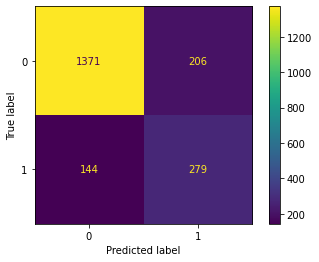

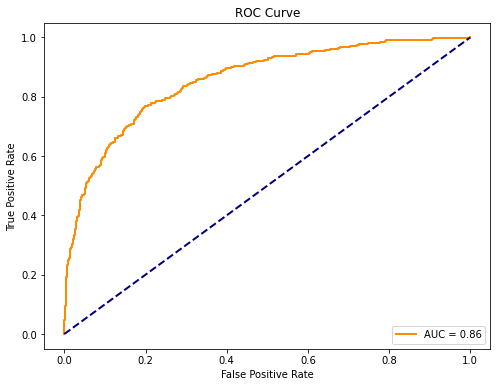

{'Accuracy': 0.825, 'Precision': 0.5752577319587628, 'Recall': 0.6595744680851063, 'F1 Score': 0.6145374449339206, 'ROC AUC': 0.8570511984481413, 'Confusion Matrix': array([[1371,  206],
       [ 144,  279]])}


In [187]:
model = RandomForestClassifier(random_state=12345, n_estimators=55, max_depth=5, min_samples_leaf=8)
model.fit(features_upsampled_train_full, target_upsampled_train_full)
metrics = evaluate_model(model, features_test, target_test) 
print(metrics)

После дообучения модели RandomForestClassifier с использованием upsample и проверки ее на тестовой выборке получены следующие показатели:

- Accuracy: 0.82
- Precision: 0.57
- Recall: 0.66
- F1 Score: 0.61
- ROC AUC: 0.85

Матрица ошибок:

[1363, 214]

[ 142, 281]

Модель RandomForestClassifier показывает хорошие показатели Precision и Recall на тестовой выборке. Она способна обнаруживать положительные объекты с высокой точностью (57%) и уровнем полноты (66%). F1-мера, которая учитывает как точность, так и полноту, составляет 0.61, что также является хорошим показателем.

ROC AUC равный 0.85 свидетельствует о хорошей способности модели разделять классы. Таким образом, модель RandomForestClassifier, обученная с использованием upsample и проверенная на тестовой выборке, демонстрирует хорошие показатели обобщения и способна хорошо справляться с дисбалансом классов.

Целью данного проекта было построение модели для прогнозирования ухода клиентов из "Бета-Банка". Важной задачей было повышение значения F1-меры до минимума 0.59. Проект был разделен на несколько этапов, начиная с загрузки и предварительной обработки данных, затем исследования баланса классов, улучшения качества модели с учетом дисбаланса, и финального тестирования.

Исследованы три модели классификации с учетом дисбаланса классов: DecisionTreeClassifier, RandomForestClassifier и LogisticRegression. DecisionTreeClassifier и RandomForestClassifier показали хорошие показатели точности и полноты. LogisticRegression демонстрирует более низкие показатели. Лучшей моделью может быть RandomForestClassifier, так как она обеспечивает хороший баланс между точностью и полнотой.

Модели, обученные после уменьшения выборки, демонстрируют хороший Recall, что означает, что они лучше способны обнаруживать положительные объекты. Однако, Precision снижается, что может быть компромиссом для повышения полноты.

Модель RandomForestClassifier, обученная с использованием увеличения выборки и проверенная на тестовой выборке, демонстрирует хорошие показатели Precision, Recall и F1 Score. ROC AUC также высокий, что свидетельствует о хорошей способности модели разделять классы. Модель успешно справляется с дисбалансом классов.

Были достигнуты важные цели. При поставленной задаче добиться F1-меры равно 0.59, получилось достичь F1-меру 0.61 на тестовой выборке. Модель RandomForestClassifier, обученная с использованием увеличением выборки, демонстрирует хорошие показатели при прогнозировании ухода клиентов из "Бета-Банка". 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*